# CNF vs RealNVP

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
mlflow.set_experiment('cnf_trace_computation')
import torch
import numpy as np

from even_flow.moons.jobs import (
    MoonsTimeEmbeddingMLPCNFJob,
    MoonsRealNVPJob
)
from even_flow.moons.dataset import MoonsDataset
from even_flow.models.cnf import TimeEmbeddingMLPCNFModel
from even_flow.models.real_nvp import RealNVPModel

/home/lucasbanunes/workspaces/even-flow-pearl-jam.mp3/.venv/lib/python3.12/site-packages/mlflow/tracking/_tracking_service/utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)
/home/lucasbanunes/workspaces/even-flow-pearl-jam.mp3/.venv/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'default' attribute with value 'min' was provided to the `Field()` function, which has no effect in the context it was used. 'default' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/h

In [2]:
train_samples = 10000
val_samples = 1000
test_samples = 1000
noise = 0.05
batch_size = 32
random_state= 943874

# Dual Moons

In [3]:
datamodule = MoonsDataset(
    train_samples=train_samples,
    val_samples=val_samples,
    test_samples=test_samples,
    noise=noise,
    batch_size=batch_size,
    random_state=random_state
)

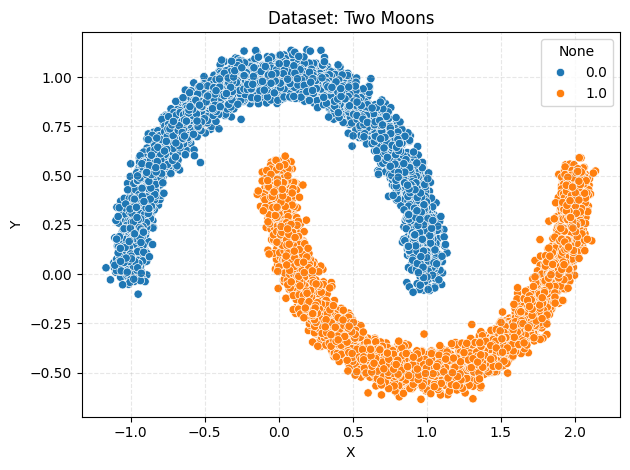

In [4]:
fig, ax = plt.subplots()
ax.grid(alpha=.3, linestyle='--')
sns.scatterplot(
    x=datamodule.train_X[:, 0].reshape(-1),
    y=datamodule.train_X[:, 1].reshape(-1),
    hue=datamodule.train_y.reshape(-1),
    ax=ax
)
ax.set(
    title='Dataset: Two Moons',
    xlabel='X',
    ylabel='Y'
)
fig.tight_layout()
moons_xlim = ax.get_xlim()
moons_ylim = ax.get_ylim()

## RealNVP

In [5]:
realnvp_job = MoonsRealNVPJob(
    datamodule=datamodule,
    model=RealNVPModel(
        features=2,
        transforms=4,
        hidden_features=[64, 64],
        monitor='val_loss',
        mode='min',
        max_epochs=50,
    )
)
realnvp_job.run()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | RealNVP          | 17.7 K | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
17.7 K    Trainable params
0         Non-trainable params
17.7 K    Total params
0.071     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


/home/lucasbanunes/workspaces/even-flow-pearl-jam.mp3/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/lucasbanunes/workspaces/even-flow-pearl-jam.mp3/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 7: 100%|██████████| 313/313 [00:03<00:00, 81.25it/s, v_num=0203, train_loss_step=0.382, val_loss=0.511, train_loss_epoch=0.514] 


2025/11/29 12:50:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 12:50:19 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/29 12:50:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/home/lucasbanunes/workspaces/even-flow-pearl-jam.mp3/.venv/lib/python3.12/site-packages/lightning/pytorch/core/module.py:449: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


'b07a73bdd91c425cb9acc3a7f67f0203'

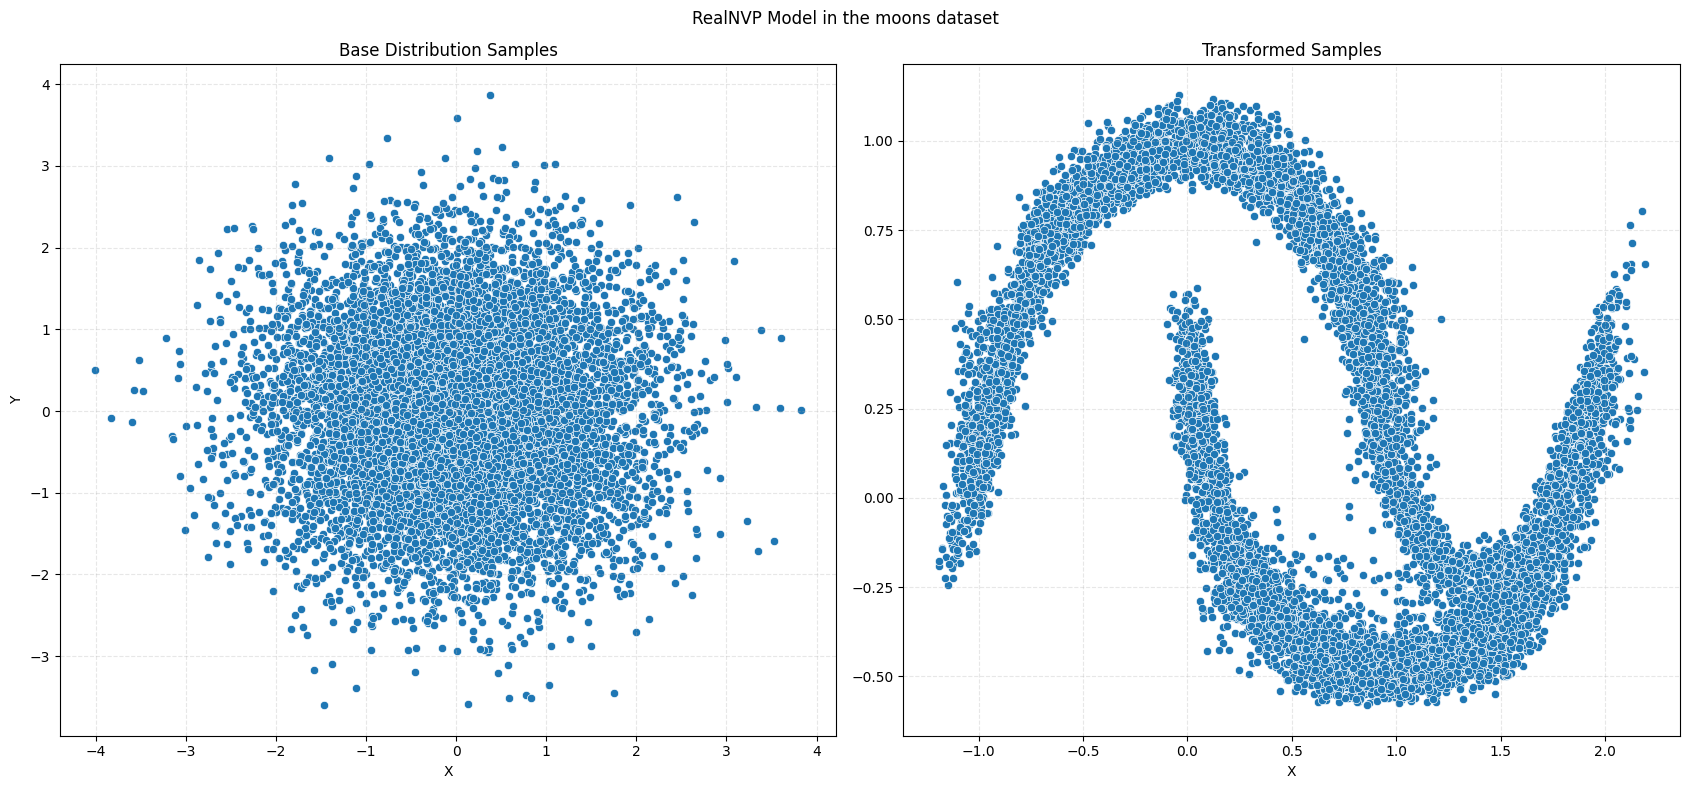

In [6]:
real_nvp_comparison_plot = realnvp_job.plot_comparison(n_samples=train_samples)
real_nvp_comparison_plot[0].suptitle('RealNVP Model in the moons dataset')
real_nvp_comparison_plot[0].tight_layout()

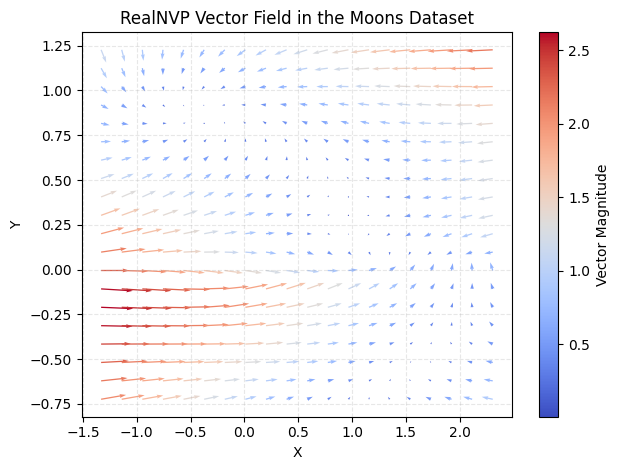

In [7]:
fig, ax = plt.subplots()
ax.grid(alpha=.3, linestyle='--')
realnvp_job.vector_field_plot(
    x=torch.linspace(moons_xlim[0], moons_xlim[1], 20),
    y=torch.linspace(moons_ylim[0], moons_ylim[1], 20),
    ax=ax,
    cmap='coolwarm'
)
ax.set(
    xlabel='X', ylabel='Y',
    title='RealNVP Vector Field in the Moons Dataset'
)
fig.tight_layout()

## Exact CNF

In [8]:
exact_cnf_job = MoonsTimeEmbeddingMLPCNFJob(
    datamodule=datamodule,
    model=TimeEmbeddingMLPCNFModel(
        vector_field=dict(
            input_dims=2,
            time_embed_dims=16,
            time_embed_freq=100,
            neurons_per_layer=10*[2],
            activations=9*['tanh'] + ['linear'],
        ),
        adjoint=True,
        base_distribution='standard_normal',
        max_epochs = 5,
        patience = 1,
        verbose=True,
        min_delta=1,
        input_shape=(2,),
    )
)
exact_cnf_job.run()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | vector_field  | TimeEmbeddingMLP | 92     | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
92        Trainable params
0         Non-trainable params
92        Total params
0.000     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


/home/lucasbanunes/workspaces/even-flow-pearl-jam.mp3/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/lucasbanunes/workspaces/even-flow-pearl-jam.mp3/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 2: 100%|██████████| 313/313 [01:43<00:00,  3.04it/s, v_num=6d56, train_loss_step=3.170, val_loss=2.770, train_loss_epoch=2.360]  


2025/11/29 12:54:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/29 12:54:10 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/29 12:54:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


'c8a5063c1b524edb8de18d065c356d56'

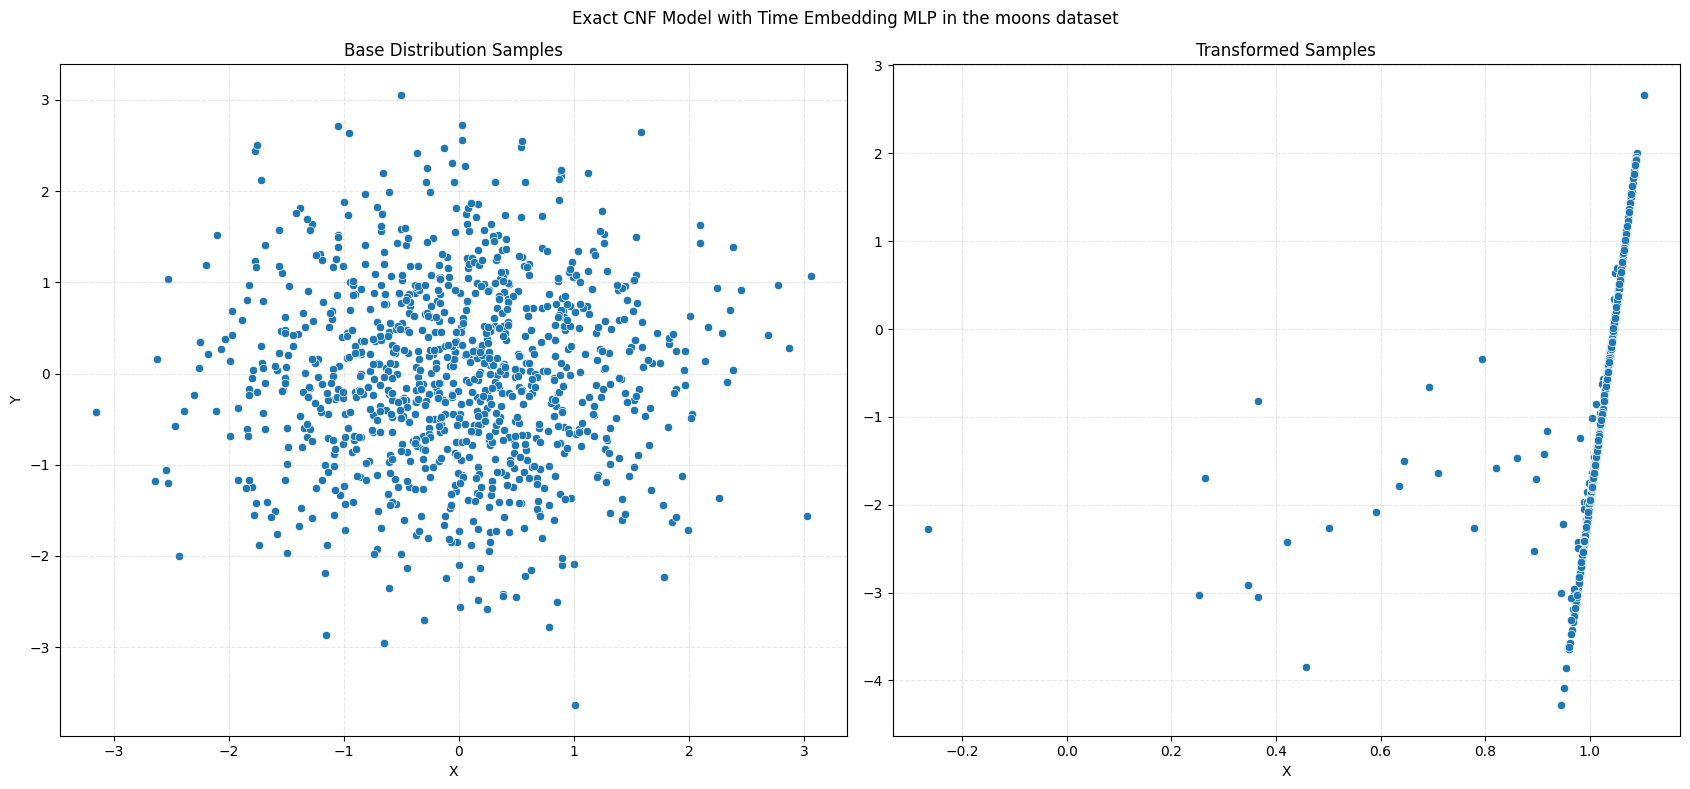

In [9]:
exact_cnf_comparison_plot = exact_cnf_job.plot_comparison(n_samples=1000)
exact_cnf_comparison_plot[0].suptitle('Exact CNF Model with Time Embedding MLP in the moons dataset')
exact_cnf_comparison_plot[0].tight_layout()

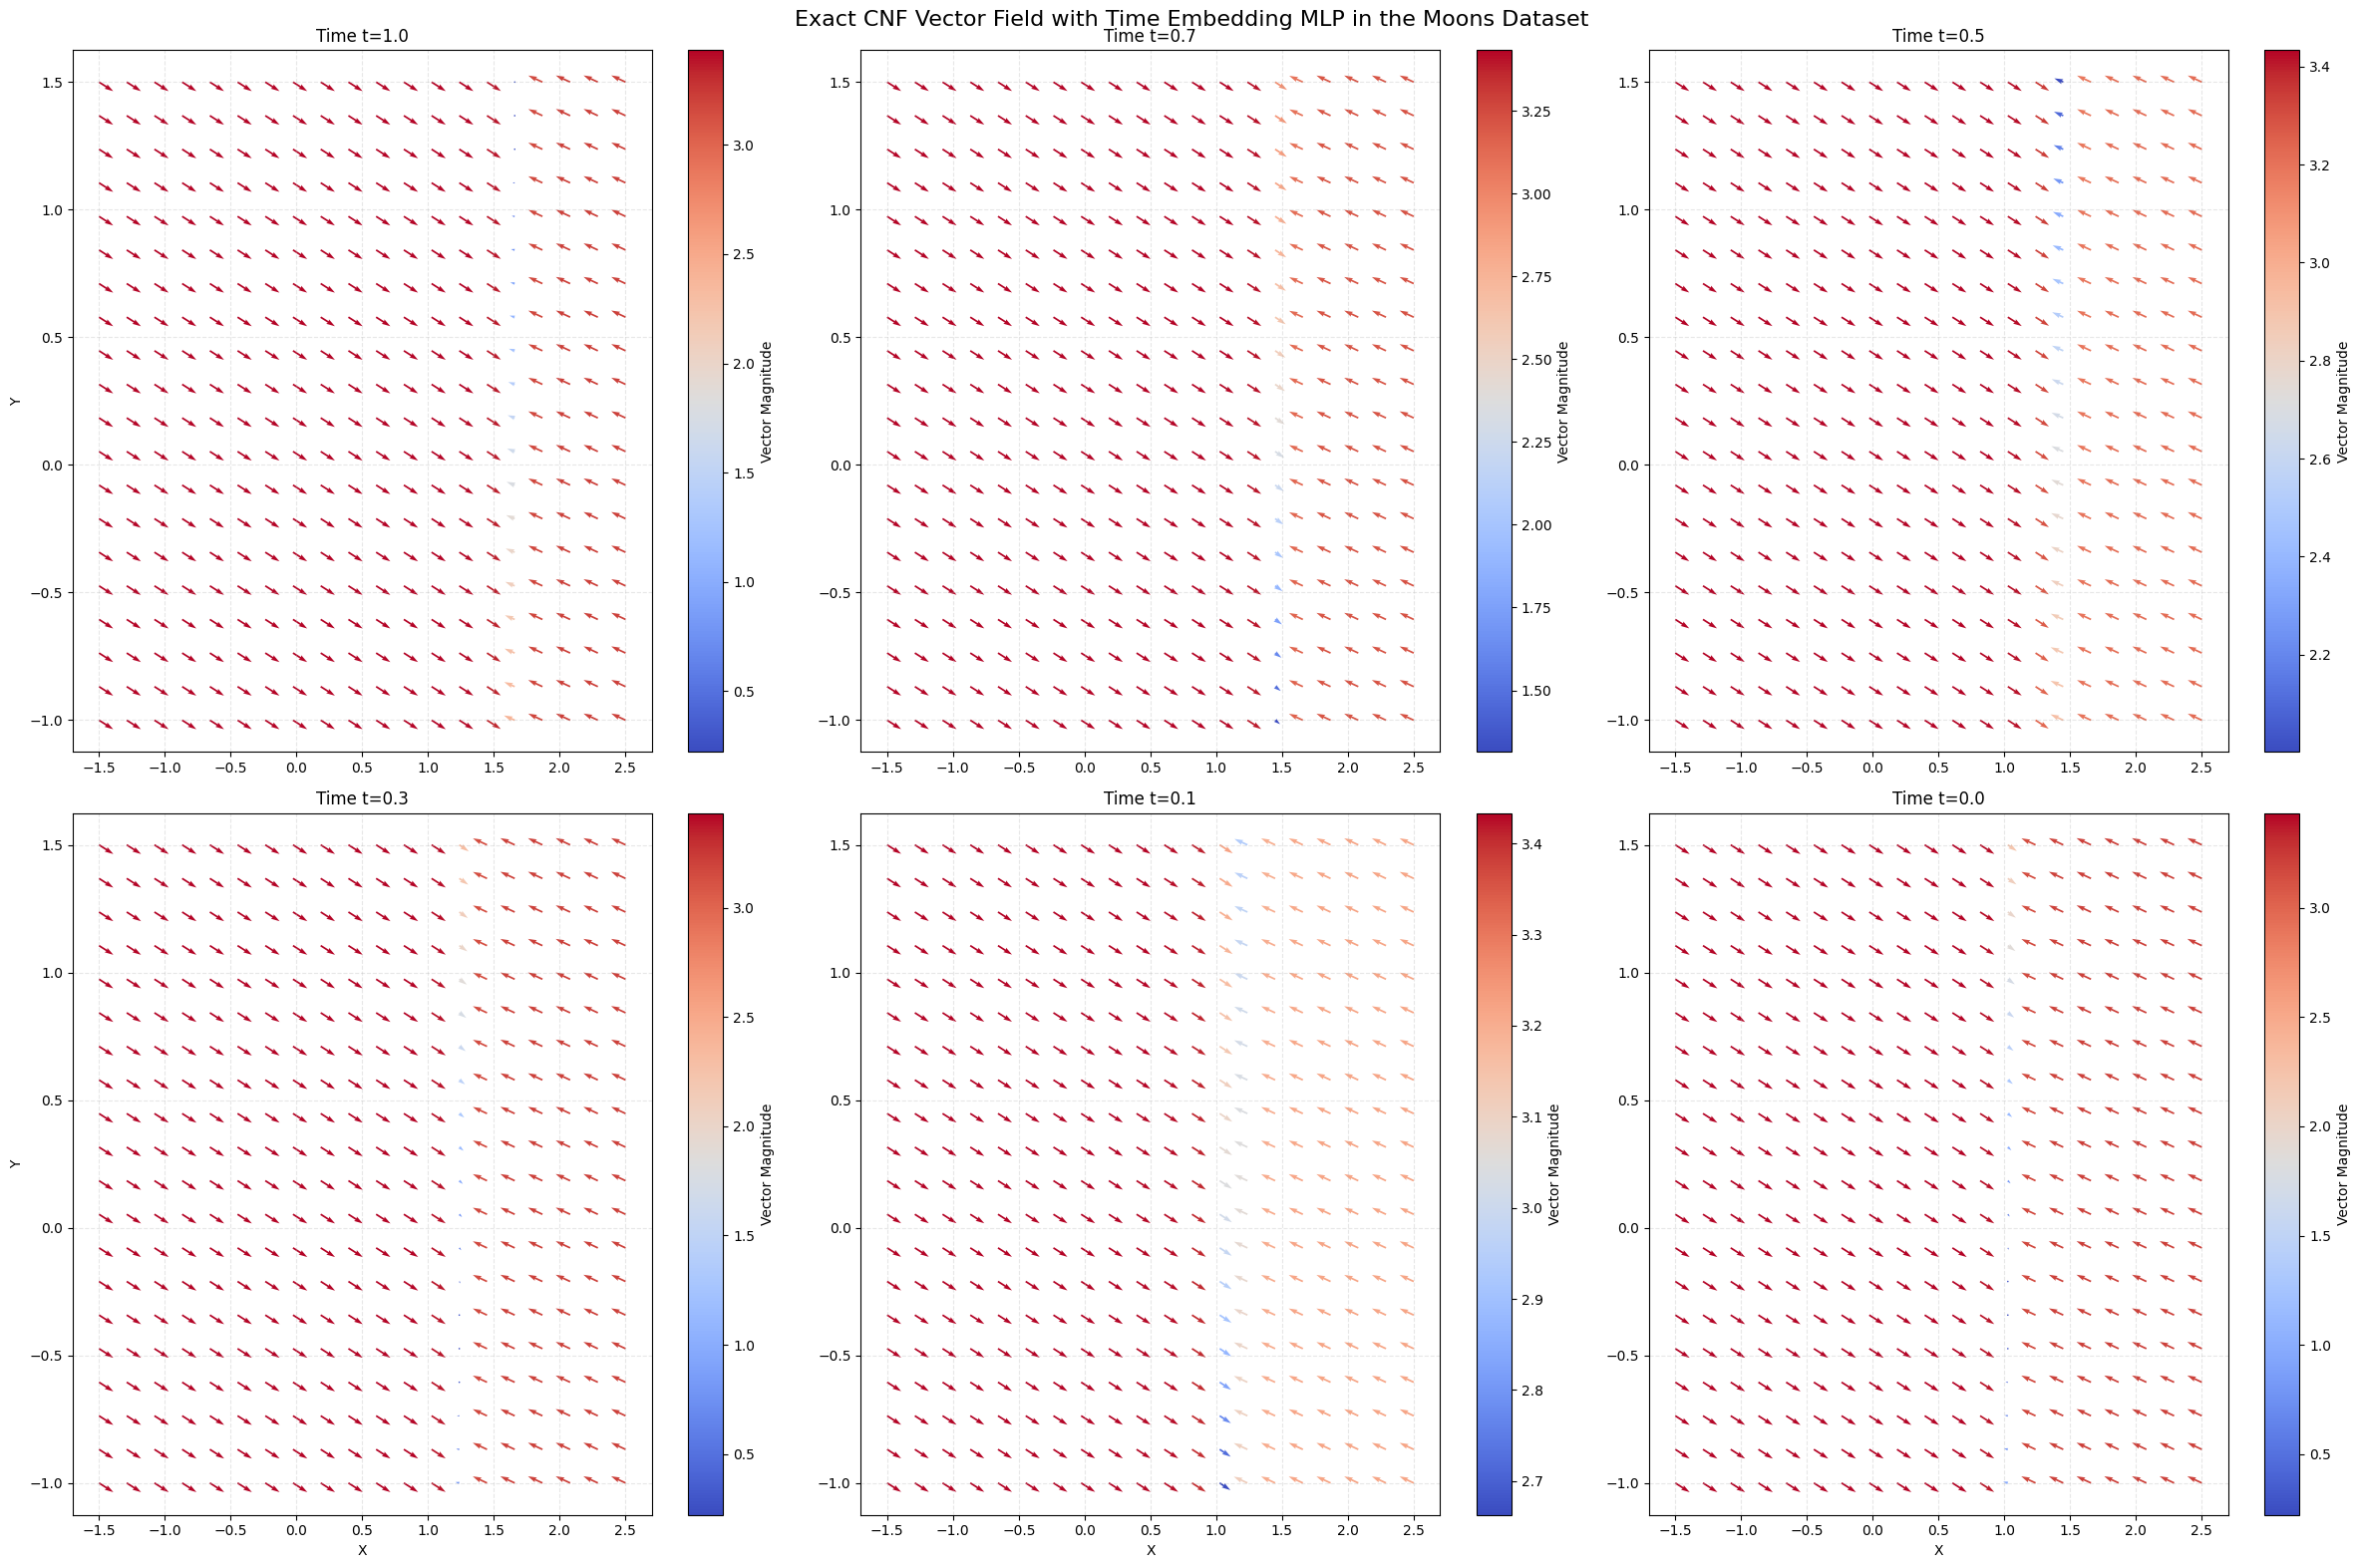

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(24, 16))
for ax in axes[-1, :].flatten():
    ax.set_xlabel('X')
for ax in axes[:, 0].flatten():
    ax.set_ylabel('Y')
times = [1.0, 0.7, 0.5, 0.3, 0.1, 0.0]
for t, ax in zip(times, axes.flatten()):
    ax.set_title(f'Time t={t}') 
    ax.grid(alpha=.3, linestyle='--')
    exact_cnf_job.vector_field_plot(
        x=torch.linspace(-1.5, 2.5, 20),
        y=torch.linspace(-1.0, 1.5, 20),
        t=t,
        ax=ax,
        cmap='coolwarm'
    )
fig.suptitle('Exact CNF Vector Field with Time Embedding MLP in the Moons Dataset', fontsize=16)
fig.tight_layout()

# MNIST